<a href="https://colab.research.google.com/github/BharathSShankar/DSA4212_Assignments/blob/bharath-exp/BayesianNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install medmnist torchmetrics
!python -m medmnist download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=621a8b26873e6797ca77fb806810b58735b4c9a3351337b6a6c74e76951cdd7b
  Stored in directory: /root/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire
100% 205615438/205615438 [01:53<00:00, 1814791.85it/s]
100% 82802576/82802576 [00:49<00:00, 1674644.40it/s]
100% 19725078/19725078 [00:07<00:00, 2668070.33it/s]
100% 54938180/54938180 [01:43<00:00, 532458.74it/s]
100% 4170669/4170669 [00:07<00:00, 545168.73it/s]
100% 3291041/3291041 [00:06<00:00, 535135.17it/s]
100% 559580/559580 [00:01<00:00, 516024.26it/s]
100% 35461855/35461855 [01:06<00:00, 535549.27it/s]
100

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [5]:
import medmnist
from medmnist import INFO, Evaluator

In [6]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])


In [7]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PI = 0.5
SIGMA_1 = torch.FloatTensor([np.exp(1)]).to(DEVICE)
SIGMA_2 = torch.FloatTensor([np.exp(-4)]).to(DEVICE)

In [9]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-np.log(np.sqrt(2 * np.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [10]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

In [11]:
class BayesianDense(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.1, 0.1))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-7,-5))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)

        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.1, 0.1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-7,-5))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)

        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)
    
    def kl_loss(self):
        kl = self.weight_prior.log_prob(self.weight.mu) - self.weight.log_prob(self.weight.mu)
        kl += self.bias_prior.log_prob(self.bias.mu) - self.bias.log_prob(self.bias.mu)
        return kl.sum()

In [12]:
class BayesianConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, k_size):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k_size = k_size

        self.weight_mu = nn.Parameter(torch.Tensor(out_channels, in_channels, k_size, k_size).uniform_(-0.1, 0.1))
        self.weight_rho = nn.Parameter(torch.Tensor(out_channels, in_channels, k_size,k_size).uniform_(-7,-5))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)

        self.bias_mu = nn.Parameter(torch.Tensor(out_channels).uniform_(-0.1, 0.1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_channels).uniform_(-7,-5))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)

        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.conv2d(input, weight, bias)
    
    def kl_loss(self):
        kl = self.weight_prior.log_prob(self.weight.mu) - self.weight.log_prob(self.weight.mu)
        kl += self.bias_prior.log_prob(self.bias.mu) - self.bias.log_prob(self.bias.mu)
        return kl.sum()

In [13]:
class BayesianNeuralNetFC(nn.Module):
    def __init__(self, layers_dims, input_size, n_classes):
        super().__init__()
        self.inputLayer = BayesianDense(input_size, layers_dims[0])
        layer_list = []
        for i in range(1, len(layers_dims)):
            layer_list.append(BayesianDense(layers_dims[i - 1], layers_dims[i]))
        self.linears = nn.ModuleList(layer_list)
        self.outputLayer = BayesianDense(layers_dims[-1], n_classes)
    
    def forward(self, input, sample=False, calculate_log_probs=False):
        x = nn.Flatten()(input)
        x = self.inputLayer(x, sample, calculate_log_probs)
        x = F.relu(x)
        x = nn.Dropout(p=0.1)(x)
        for layer in self.linears:
            x = layer(x, sample, calculate_log_probs)
            x = F.relu(x)
            x = nn.Dropout(p=0.1)(x)
        x = self.outputLayer(x)
        return x

    def kl_loss(self):
        kl = 0.0
        for layer in self.linears:
            kl += layer.kl_loss()
        kl += self.inputLayer.kl_loss()
        kl += self.outputLayer.kl_loss()
        return kl

In [19]:
def train_bayesian_net(net, train_loader, test_loader, is_bayes=False, n_epochs=3, lr=3e-4, log_interval=10, beta=1e-7):
    # Define loss function and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    # Move model to device
    net.to(DEVICE)

    # Training loop
    for epoch in range(n_epochs):
        # Training mode
        net.train()
        train_loss = 0
        ce_loss = 0
        kl_loss = 0
        correct = 0
        total = 0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}") as t:
            for batch_idx, (data, target) in enumerate(t):
                data, target = data.to(DEVICE), target.to(DEVICE)

                # Forward pass
                optimizer.zero_grad()
                outputs = net(data)

                # Compute loss and update model
                if is_bayes:
                    ce_loss = loss_func(outputs, target.T[0])
                    kl_loss = net.kl_loss()
                    loss = ce_loss - beta * kl_loss
                else:
                    loss = loss_func(outputs, target.T[0])

                loss.backward()
                optimizer.step()

                # Update training statistics
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += data.shape[0]
                correct += predicted.eq(target.T[0]).sum().item()

                # Log training progress
                if batch_idx % log_interval == 0:
                    train_acc = correct / total
                    train_loss /= log_interval
                    ce_loss /= log_interval
                    kl_loss /= log_interval
                    t.set_postfix(ce_loss=f"{ce_loss:.6f}", kl_loss=f"{kl_loss:.6f}", loss=f"{train_loss:.6f}", accuracy=f"{train_acc:.2f}")
                    train_loss = 0
                    ce_loss = 0
                    kl_loss = 0
                    correct = 0
                    total = 0

        # Evaluation mode
        net.eval()
        test_loss = 0
        ce_loss = 0
        kl_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)

                # Forward pass
                outputs = net(data)

                # Compute loss and update evaluation statistics
                if is_bayes:
                    ce_loss = loss_func(outputs, target.T[0])
                    kl_loss = net.kl_loss()
                    loss = ce_loss - beta * kl_loss
                else:
                    loss = loss_func(outputs, target.T[0])

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += data.shape[0]
                correct += predicted.eq(target.T[0]).sum().item()

        # Log evaluation statistics
        test_acc = 100. * correct / total
        test_loss /= len(test_loader)
        if is_bayes:
            print('Test set: Average loss: {:.4f}, CE loss: {:.4f}, KL loss: {:.4f}, Accuracy: {:.2f}%\n'.format(
                test_loss, ce_loss, kl_loss, test_acc))
        else:
            print('Test set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(
                test_loss,test_acc))

In [ ]:
net = BayesianNeuralNetFC([128, 256, 64], 3 * 28 * 28, 9)
train_bayesian_net(net, train_loader, test_loader, is_bayes = True)

In [ ]:
net= nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.LazyLinear(64),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.LazyLinear(9),
    nn.Softmax(dim = 1)
).to(DEVICE)
train_bayesian_net(net, train_loader, test_loader)

In [16]:
class BayesianNeuralNetConv(nn.Module):
    def __init__(self, channel_list, input_channels, n_classes):
        super().__init__()
        self.inputLayer = BayesianConv2D(input_channels, channel_list[0], k_size=3)
        layer_list = []
        for i in range(1, len(channel_list)):
            layer_list.append(BayesianConv2D(channel_list[i - 1], channel_list[i], k_size=1))
        self.convs = nn.ModuleList(layer_list)
        self.fc = BayesianDense(channel_list[-1] * 9, n_classes)
    
    def forward(self, input, sample=False, calculate_log_probs=False):
        x = self.inputLayer(input, sample, calculate_log_probs)
        x = F.rrelu(x)
        x = F.max_pool2d(x, 2)
        for conv in self.convs:
            x = conv(x, sample, calculate_log_probs)
            x = F.rrelu(x)
            x = F.max_pool2d(x, 2)
        x = nn.Flatten()(x)
        x = self.fc(x, sample, calculate_log_probs)
        return x
    
    def kl_loss(self):
        kl = 0.0
        for layer in self.convs:
            kl += layer.kl_loss()
        kl += self.inputLayer.kl_loss()
        kl += self.fc.kl_loss()
        return kl


In [20]:
net = BayesianNeuralNetConv([128, 256, 512], 3, 9)
train_bayesian_net(net, train_loader, test_loader, is_bayes = True)

Epoch 1: 100%|██████████| 704/704 [00:59<00:00, 11.76it/s, accuracy=0.75, ce_loss=0.077734, kl_loss=-117542.554688, loss=0.837853]


Test set: Average loss: 0.9821, CE loss: 0.6340, KL loss: -1175367.1250, Accuracy: 77.20%



Epoch 2: 100%|██████████| 704/704 [00:58<00:00, 12.00it/s, accuracy=0.80, ce_loss=0.077725, kl_loss=-116911.304688, loss=0.689393]


Test set: Average loss: 1.0101, CE loss: 0.6897, KL loss: -1169098.2500, Accuracy: 73.76%



Epoch 3: 100%|██████████| 704/704 [00:58<00:00, 12.01it/s, accuracy=0.81, ce_loss=0.060770, kl_loss=-116361.023438, loss=0.633698]


Test set: Average loss: 1.1381, CE loss: 0.6932, KL loss: -1163561.7500, Accuracy: 74.51%



In [21]:
def get_prediction_probabilities(model, test_loader, n=10):
    model.eval()
    logits = torch.zeros((n, len(test_loader.dataset), model.fc.out_features))
    labels = torch.zeros((len(test_loader.dataset)))
    with torch.no_grad():
        for i in range(n):
            for j, (inputs, targets) in enumerate(test_loader):
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                outputs = model(inputs, True, True)
                logits[i, j*test_loader.batch_size:(j+1)*test_loader.batch_size] = outputs
                labels[j*test_loader.batch_size:(j+1)*test_loader.batch_size] = targets.T[0]
    probabilities = torch.softmax(logits, dim=-1)
    mean_probs = torch.mean(probabilities, dim=0)
    predictive_entropy = -torch.sum(mean_probs * torch.log(mean_probs), dim=-1)
    return logits, probabilities, predictive_entropy, labels

logits, probabilities, predictive_entropy, labels = get_prediction_probabilities(net, test_loader, 10)

In [22]:
print(logits[:, 1])

tensor([[-2.3357, -2.8012, -3.4424, -7.2041,  3.0641, -1.7646,  0.5326,  1.2331,
         -3.1218],
        [-2.2026, -2.6125, -3.9419, -6.3811,  3.0603, -2.0508,  0.7576,  0.7787,
         -2.8577],
        [-2.2714, -2.9328, -3.4846, -6.6636,  2.8130, -1.5303,  0.8061,  1.2011,
         -2.9003],
        [-2.3162, -2.5014, -3.8882, -6.8814,  3.2804, -1.8435,  0.7750,  0.9494,
         -3.0818],
        [-2.3098, -2.8382, -3.4280, -7.1369,  3.0445, -1.4302,  0.6599,  1.4373,
         -3.0748],
        [-2.1641, -2.8708, -3.4462, -7.1711,  3.1172, -1.1977,  0.4775,  1.5482,
         -3.1859],
        [-2.1828, -2.9823, -3.5555, -7.5515,  3.1620, -1.1902,  0.7007,  1.4106,
         -2.9262],
        [-1.9803, -2.5128, -3.7384, -6.4184,  3.2800, -1.6811,  0.5380,  1.1982,
         -3.2883],
        [-2.2732, -2.7890, -3.8550, -6.3579,  3.0107, -1.6099,  0.6252,  1.1661,
         -3.1660],
        [-2.1451, -2.5705, -3.7246, -6.9516,  3.1551, -1.4519,  0.6970,  1.2088,
         -2.9551]])

In [23]:
print(probabilities[:, 1])

tensor([[3.5888e-03, 2.2531e-03, 1.1866e-03, 2.7582e-05, 7.9445e-01, 6.3531e-03,
         6.3189e-02, 1.2732e-01, 1.6352e-03],
        [4.2445e-03, 2.8172e-03, 7.4549e-04, 6.5033e-05, 8.1939e-01, 4.9404e-03,
         8.1923e-02, 8.3672e-02, 2.2046e-03],
        [4.5482e-03, 2.3475e-03, 1.3519e-03, 5.6275e-05, 7.3449e-01, 9.5436e-03,
         9.8712e-02, 1.4653e-01, 2.4249e-03],
        [3.1073e-03, 2.5820e-03, 6.4514e-04, 3.2341e-05, 8.3743e-01, 4.9849e-03,
         6.8371e-02, 8.1400e-02, 1.4450e-03],
        [3.5945e-03, 2.1192e-03, 1.1750e-03, 2.8792e-05, 7.6029e-01, 8.6626e-03,
         7.0046e-02, 1.5241e-01, 1.6727e-03],
        [3.9006e-03, 1.9241e-03, 1.0822e-03, 2.6099e-05, 7.6696e-01, 1.0253e-02,
         5.4743e-02, 1.5971e-01, 1.4039e-03],
        [3.7227e-03, 1.6735e-03, 9.4346e-04, 1.7349e-05, 7.7993e-01, 1.0045e-02,
         6.6546e-02, 1.3535e-01, 1.7701e-03],
        [4.3040e-03, 2.5271e-03, 7.4188e-04, 5.0869e-05, 8.2866e-01, 5.8053e-03,
         5.3404e-02, 1.0334e-0

In [24]:
print(labels[1])

tensor(4.)


In [25]:
import matplotlib.pyplot as plt

def display_image_with_probabilities(image, probabilities):
    """
    Displays an RGB image in the left pane and shows the calculated probabilities on the right pane.

    Args:
    - image: A PyTorch tensor representing the RGB image.
    - probabilities: A PyTorch tensor representing the predicted probabilities.

    Returns: None
    """
    image = image.detach().cpu().numpy()

    # Convert the probabilities tensor to a NumPy array
    probabilities = probabilities.detach().cpu().numpy()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(ncols=2)

    # Display the image in the left subplot
    ax1.imshow(image.transpose(1,2,0))

    # Set the title of the left subplot
    ax1.set_title('Image')

    # Create a bar chart of the probabilities in the right subplot
    ax2.barh(range(probabilities.shape[1]), probabilities.squeeze())

    # Set the y-axis tick labels to the class names
    ax2.set_yticks(range(probabilities.shape[1]))
    ax2.set_yticklabels(range(probabilities.shape[1]))

    # Set the title of the right subplot
    ax2.set_title('Predicted Probabilities')

    # Show the plot
    plt.show()


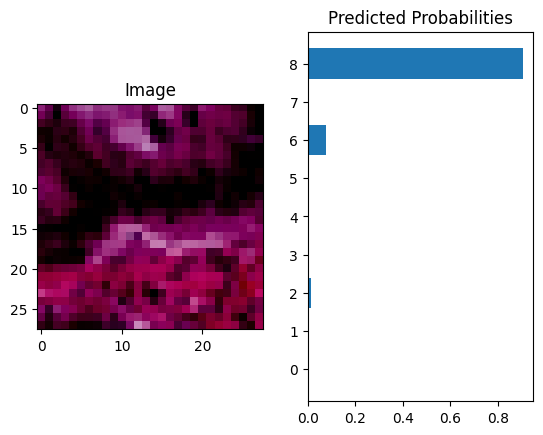

tensor([8])


In [26]:
images, labels = next(iter(test_loader))
index = np.random.randint(0, 127)
image = images[index]
label = labels[index]
logits = net(image.unsqueeze(0).to(DEVICE))
probabilities = torch.softmax(logits, dim=1)
display_image_with_probabilities(image, probabilities)
print(label)

In [37]:
import torch

import torchmetrics

# Define the device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the batch size for the DataLoader
targets = []
probs = []

for images, labels in tqdm(test_loader):
    # Move the data to the device
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Get the predicted probabilities from the model
    logits = net(images)
    probabilities = torch.softmax(logits, dim=1)

    # Append the targets and predicted probabilities to the lists.squeeze())
    targets.append(labels.detach())
    probs.append(probabilities.detach())

# Concatenate the targets and predicted probabilities
targets = torch.cat(targets).flatten()
probs = torch.cat(probs)


# Calculate the ECE
ece = torchmetrics.functional.classification.multiclass_calibration_error(probs, targets, num_classes=n_classes)



100%|██████████| 29/29 [00:02<00:00, 11.01it/s]

torch.Size([7180])


In [38]:
print(ece)

tensor(0.0488, device='cuda:0')
